In [ ]:
# BLOCK 1 — mount drive & unzip (aman kalau sudah ada)
from google.colab import drive
drive.mount('/content/drive')

import zipfile, os, shutil

zip_path = "/content/drive/MyDrive/MAGISTER/fracatlas.v2i.yolov11.zip"
dataset_original = "/content/drive/MyDrive/dataset_original"

# hapus jika sudah ada sementara agar fresh
shutil.rmtree(dataset_original, ignore_errors=True)

# extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_original)

print("✔ ZIP diekstrak ke:", dataset_original)
print("List top-level:", os.listdir(dataset_original))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ ZIP diekstrak ke: /content/drive/MyDrive/dataset_original
List top-level: ['README.dataset.txt', 'README.roboflow.txt', 'data.yaml', 'test', 'train', 'valid']


In [ ]:
# BLOCK 2 — load class names dari data.yaml
import yaml, os
yaml_path = os.path.join(dataset_original, "data.yaml")
with open(yaml_path, "r") as f:
    data_cfg = yaml.safe_load(f)

class_names = data_cfg.get("names") or data_cfg.get("names", [])
print("Jumlah kelas:", len(class_names))
print("Class names (index -> name):")
for i, n in enumerate(class_names):
    print(i, ":", n)


Jumlah kelas: 6
Class names (index -> name):
0 : fractured
1 : hand
2 : hardware
3 : hip
4 : leg
5 : shoulder


In [ ]:
# BLOCK 3 — count distribusi sebelum augmentasi
from collections import Counter
from glob import glob

splits = ["train", "valid", "test"]

def count_instances(root, split):
    lbl_dir = os.path.join(root, split, "labels")
    c = Counter()
    if not os.path.exists(lbl_dir):
        return c
    for f in os.listdir(lbl_dir):
        if not f.endswith(".txt"):
            continue
        with open(os.path.join(lbl_dir, f), "r") as fh:
            for line in fh:
                cls = int(line.split()[0])
                c[class_names[cls]] += 1
    return c

before = {}
print("DISTRIBUSI SEBELUM AUGMENTASI\n")
for s in splits:
    before[s] = count_instances(dataset_original, s)
    print(s.upper())
    for cls, v in before[s].most_common():
        print(f"{cls:20} → {v}")
    print("---------------")


DISTRIBUSI SEBELUM AUGMENTASI

TRAIN
leg                  → 1769
hand                 → 1105
fractured            → 649
shoulder             → 256
hip                  → 231
hardware             → 82
---------------
VALID
leg                  → 526
hand                 → 310
fractured            → 172
hip                  → 63
shoulder             → 52
hardware             → 29
---------------
TEST
leg                  → 267
hand                 → 149
fractured            → 82
hip                  → 40
shoulder             → 28
hardware             → 10
---------------


In [ ]:
# BLOCK 4 — target augmentasi (train only)
# Map nama kelas ke target
train_counts = before["train"]

# Pastikan kelas ada
targets = {}
# define targets per request:
# fractured -> 900
# hip -> 2x current
# shoulder -> 2x current
# hardware -> 5x current

targets["fractured"] = 900
targets["hip"] = train_counts.get("hip", 0) * 2
targets["shoulder"] = train_counts.get("shoulder", 0) * 2
targets["hardware"] = train_counts.get("hardware", 0) * 5

# compute needed (only if positive)
needed = {}
for k, tgt in targets.items():
    curr = train_counts.get(k, 0)
    need = int(max(0, tgt - curr))
    needed[k] = need

print("Target & kebutuhan tambahan (train):")
for k in needed:
    print(f"{k:10} | current={train_counts.get(k,0):4} -> target={targets[k]:4} | need +{needed[k]}")


Target & kebutuhan tambahan (train):
fractured  | current= 649 -> target= 900 | need +251
hip        | current= 231 -> target= 462 | need +231
shoulder   | current= 256 -> target= 512 | need +256
hardware   | current=  82 -> target= 410 | need +328


In [ ]:
# BLOCK 5 — copy dataset original ke output (agar original aman)
output_root = "/content/drive/MyDrive/dataset_augmented"
shutil.rmtree(output_root, ignore_errors=True)
shutil.copytree(dataset_original, output_root)
print("Dataset disalin ke:", output_root)

# helper fungsi baca labels YOLO
def read_labels_yolo(path):
    boxes = []
    if not os.path.exists(path):
        return boxes
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5: continue
            cls = int(parts[0])
            vals = list(map(float, parts[1:5]))
            boxes.append((cls, vals))  # (class_id, [x,y,w,h])
    return boxes

def write_labels_yolo(path, boxes):
    with open(path, "w") as f:
        for cls, (x, y, w, h) in boxes:
            f.write(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")


Dataset disalin ke: /content/drive/MyDrive/dataset_augmented


In [ ]:
# BLOCK 6 — augmentation pipeline
import albumentations as A
import cv2
from tqdm import tqdm
import random
import math

transform = A.Compose([
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.4),
    A.Rotate(limit=25, p=0.7),
    A.RandomScale(scale_limit=0.2, p=0.6),
    A.RandomBrightnessContrast(p=0.6),
    A.GaussianBlur(blur_limit=5, p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [ ]:
# BLOCK 7 — prepare candidate image list (train only)
target_class_names = set([k for k in needed if needed[k] > 0])
# map class name -> class id
name2id = {n:i for i,n in enumerate(class_names)}
target_class_ids = set(name2id[n] for n in target_class_names)

train_img_dir = os.path.join(dataset_original, "train", "images")
train_lbl_dir = os.path.join(dataset_original, "train", "labels")

# collect candidates: list of tuples (img_path, label_path, set_of_class_ids_in_image)
candidates = []
for lbl_file in os.listdir(train_lbl_dir):
    if not lbl_file.endswith(".txt"): continue
    lbl_path = os.path.join(train_lbl_dir, lbl_file)
    boxes = read_labels_yolo(lbl_path)
    cls_ids_in_image = set([b[0] for b in boxes])
    if len(cls_ids_in_image & target_class_ids) > 0:
        img_file = lbl_file.replace(".txt", ".jpg")
        img_path = os.path.join(train_img_dir, img_file)
        if os.path.exists(img_path):
            candidates.append((img_path, lbl_path, cls_ids_in_image))

print(f"Candidate images for augmentation: {len(candidates)} (contain target classes)")


Candidate images for augmentation: 888 (contain target classes)


In [ ]:
# BLOCK 8 — augmentation loop with multi-label handling
out_img_dir = os.path.join(output_root, "train", "images")
out_lbl_dir = os.path.join(output_root, "train", "labels")

# current counts (mutable) based on before["train"]
curr_counts = dict(before["train"])  # name -> count

# remaining needed (mutable)
remaining = dict(needed)

# calculation of total needed sum for loop cap
total_needed = sum(remaining.values())
if total_needed == 0:
    print("Tidak ada kebutuhan augmentasi. Selesai.")
else:
    print("Total tambahan gambar yang dibutuhkan (sum of targets):", total_needed)

# prepare candidate pool indices for sampling (we will sample with replacement if needed)
cand_len = len(candidates)
if cand_len == 0:
    raise Exception("Tidak ditemukan candidate images yang berisi kelas target di train. Periksa lagi label.")

global_aug_id = 0
max_iters = max(10000, total_needed * 20)  # safety cap
iters = 0
pbar = tqdm(total=total_needed, desc="Augmenting")

# helper to decrement remaining when an image containing multiple target classes is augmented
def update_counts_and_remaining(cls_ids_in_image):
    global curr_counts, remaining
    contributed = 0
    for cid in cls_ids_in_image:
        cname = class_names[cid]
        if cname in remaining and remaining[cname] > 0:
            curr_counts[cname] += 1
            remaining[cname] = max(0, remaining[cname] - 1)
            contributed += 1
    return contributed

# Augmentation loop
while sum(remaining.values()) > 0 and iters < max_iters:
    iters += 1
    # sample random candidate (so images with multiple target classes may help multiple classes)
    idx = random.randrange(cand_len)
    img_path, lbl_path, cls_ids_in_image = candidates[idx]

    # read original image & labels
    img = cv2.imread(img_path)
    orig_boxes = read_labels_yolo(lbl_path)  # list of (cls, [x,y,w,h])
    if len(orig_boxes) == 0:
        continue

    bboxes = [b[1] for b in orig_boxes]
    class_labels_for_aug = [class_names[b[0]] for b in orig_boxes]  # albumentations label_fields uses text labels but we will map back
    try:
        augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels_for_aug)
    except Exception as e:
        # skip problematic transforms occasionally
        continue

    aug_img = augmented["image"]
    aug_bboxes = augmented["bboxes"]
    aug_cls_labels = augmented["class_labels"]  # these are class names

    # convert aug_cls_labels back to class ids
    aug_cls_ids = [name2id[nm] for nm in aug_cls_labels]

    # save with unique name
    global_aug_id += 1
    base_orig = os.path.basename(img_path).rsplit(".",1)[0]
    new_fname = f"{base_orig}_aug{global_aug_id}.jpg"
    out_img_path = os.path.join(out_img_dir, new_fname)
    out_lbl_path = os.path.join(out_lbl_dir, new_fname.replace(".jpg", ".txt"))

    # write image
    cv2.imwrite(out_img_path, aug_img)
    # write labels in YOLO format
    boxes_to_write = []
    for cid, (x,y,w,h) in zip(aug_cls_ids, aug_bboxes):
        boxes_to_write.append((cid, (x,y,w,h)))
    write_labels_yolo(out_lbl_path, boxes_to_write)

    # update counts & remaining based on classes present in this augmented image
    contributed = update_counts_and_remaining(set(aug_cls_ids))
    # update progress bar by how many target-class contributions this augmentation provided
    for cname in class_names:
        pass
    if contributed > 0:
        # count down pbar by contributed (but ensure not to exceed total_needed)
        pbar.update(contributed)

    # safety: if no contribution (i.e., image had classes but none were in remaining), continue
    # continue loop until all remaining are zero
pbar.close()

print("Done augmentation loop. iterations:", iters)
print("Remaining after loop:", remaining)
print("Final counts sample (some classes):")
for k in targets:
    print(k, "->", curr_counts.get(k,0))


Total tambahan gambar yang dibutuhkan (sum of targets): 1066


Augmenting: 100%|██████████| 1066/1066 [03:52<00:00,  4.58it/s]

Done augmentation loop. iterations: 4466
Remaining after loop: {'fractured': 0, 'hip': 0, 'shoulder': 0, 'hardware': 0}
Final counts sample (some classes):
fractured -> 900
hip -> 462
shoulder -> 512
hardware -> 410


In [ ]:
# BLOCK 9 — count after augment
def count_instances_from_root(root, split):
    lbl_dir = os.path.join(root, split, "labels")
    c = Counter()
    if not os.path.exists(lbl_dir): return c
    for f in os.listdir(lbl_dir):
        if not f.endswith(".txt"): continue
        with open(os.path.join(lbl_dir, f), "r") as fh:
            for line in fh:
                cid = int(line.split()[0])
                c[class_names[cid]] += 1
    return c

after = {}
print("\nDISTRIBUSI SESUDAH AUGMENTASI\n")
for s in splits:
    after[s] = count_instances_from_root(output_root, s)
    print(s.upper())
    for cls, v in after[s].most_common():
        print(f"{cls:20} → {v}")
    print("---------------")



DISTRIBUSI SESUDAH AUGMENTASI

TRAIN
fractured            → 3904
hand                 → 3612
leg                  → 3304
shoulder             → 1531
hip                  → 1393
hardware             → 537
---------------
VALID
leg                  → 526
hand                 → 310
fractured            → 172
hip                  → 63
shoulder             → 52
hardware             → 29
---------------
TEST
leg                  → 267
hand                 → 149
fractured            → 82
hip                  → 40
shoulder             → 28
hardware             → 10
---------------


In [ ]:
# BLOCK 10 — generate data.yaml
new_yaml = {
    "train": os.path.join(output_root, "train", "images"),
    "val": os.path.join(output_root, "valid", "images"),
    "test": os.path.join(output_root, "test", "images"),
    "nc": len(class_names),
    "names": class_names
}
with open(os.path.join(output_root, "data.yaml"), "w") as f:
    yaml.dump(new_yaml, f)
print("✔ data.yaml saved to", os.path.join(output_root, "data.yaml"))


✔ data.yaml saved to /content/drive/MyDrive/dataset_augmented/data.yaml


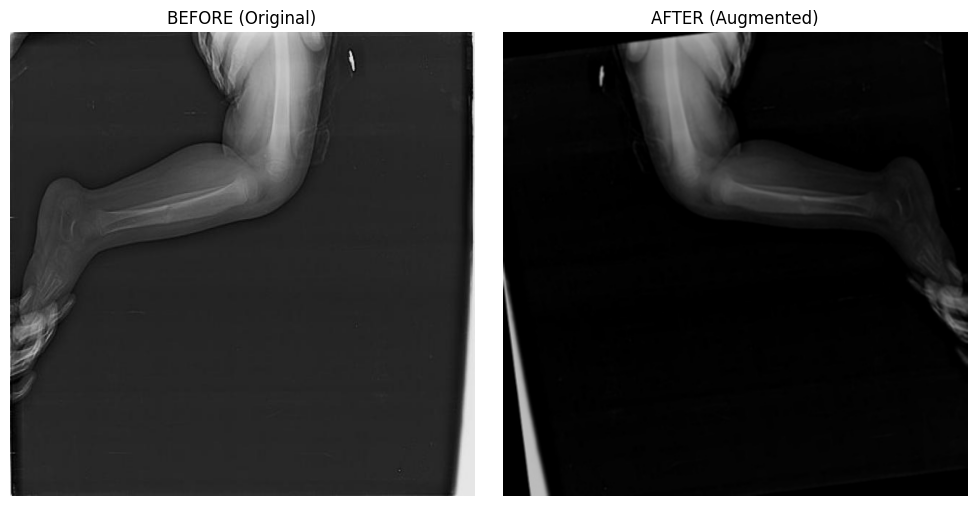

🔹 Original: IMG0002407_jpg.rf.68cff6dbd0ef6040012659a6b05cbe54.jpg
🔹 Augmented: IMG0002407_jpg.rf.68cff6dbd0ef6040012659a6b05cbe54_aug154.jpg


In [ ]:
import random
import matplotlib.pyplot as plt
import cv2
import os

train_img_dir = "/content/drive/MyDrive/dataset_augmented/train/images"

all_files = os.listdir(train_img_dir)

paired_originals = []
for f in all_files:
    if "_aug" not in f:
        base = os.path.splitext(f)[0]
        # cek apakah ada pasangan _aug
        has_aug = any(g.startswith(base + "_aug") for g in all_files)
        if has_aug:
            paired_originals.append(f)

if len(paired_originals) == 0:
    raise Exception("Tidak ada gambar original yang memiliki pasangan aug!")

orig_file = random.choice(paired_originals)
base_name = os.path.splitext(orig_file)[0]

aug_candidates = [f for f in all_files if f.startswith(base_name + "_aug")]

aug_file = random.choice(aug_candidates)

# VISUALISASI before & after
plt.figure(figsize=(10,5))

img_before = cv2.imread(os.path.join(train_img_dir, orig_file))
img_before = cv2.cvtColor(img_before, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.title("BEFORE (Original)")
plt.imshow(img_before)
plt.axis("off")

img_after = cv2.imread(os.path.join(train_img_dir, aug_file))
img_after = cv2.cvtColor(img_after, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.title("AFTER (Augmented)")
plt.imshow(img_after)
plt.axis("off")

plt.tight_layout()
plt.show()

print("🔹 Original:", orig_file)
print("🔹 Augmented:", aug_file)


In [ ]:
import shutil
from google.colab import files

src_dir = "/content/drive/MyDrive/dataset_augmented"
zip_path = "/content/dataset_augmented.zip"

shutil.make_archive("/content/dataset_augmented", 'zip', src_dir)
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>